# Practical Session - Unsupervised Learning

This Practical session is about unsupervised learning, and more specifically about dimensionality reduction using the PCA and ICA algorithms. You will first work on toy examples, and then apply the methods on a real face dataset.

Please answer the questions and complete the code where you see (`XXXXXXXXXX`). 

First let's load the functions we will use

In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
plt.close('all')

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans

from scipy import linalg as LA
from scipy.stats import ortho_group
from scipy.stats import gennorm


import math

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from scipy.io import loadmat

# I - Toy examples
## I - 1) Dataset generation

As mentionned, you will first work on toy datasets. The next three functions are used to generate the data and plot the results.

In [2]:
def generate_scenario(scenario=3, n_samples0 = 100, n_samples1 = 30):

    y = np.concatenate((np.zeros([n_samples0,1]) , np.ones([n_samples1,1])) , axis=0)

    if scenario == 1: 
        # Separate Gaussian
        mean0 = [2, 3]
        mean1 = [12, 14]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = 2 ** 2 * np.eye(2)
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
    elif scenario == 2:
        # Overlapping Gaussian
        mean0 = [2, 3]
        mean1 = [5, 7]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = [[2, 3], [3 ,6]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
        
    elif scenario == 3:
        # Overlapping Gaussian
        mean0 = [0, 0]
        mean1 = [0, 0]
        cov0 = [[50, 15], [15, 6]]#cov0 = [[50, 4], [4, 2]]
        cov1 = [[2, 0], [0 ,50]]#cov1 = [[2, 0], [0 ,50]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
        
    elif scenario == 4:
        # Circles
        # 1 circle
        angle0=np.linspace(0, 2 * np.pi, n_samples0);
        X0=np.vstack((8*np.cos(angle0) , 8*np.sin(angle0))).T
        
        # 2 circle
        angle1=np.linspace(0, 2 * np.pi, n_samples1);
        X1=np.vstack((2*np.cos(angle1) , 2*np.sin(angle1))).T

    return X0,X1,y

def plotResults(X0=None,X1=None,y=None,U=None,Y=None,const=1,title=''):

    X=np.concatenate((X0,X1),axis=0)
    
    N0=np.sum(y==0)
    N1=np.sum(y==1)
    
    fig=plt.figure(figsize=(17, 6))
    
    ax  = fig.add_subplot(1, 3, 1)
    plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
    plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
    if U is not None:
        average=X.mean(axis=0)
        sd=LA.norm(X.std(axis=0))
        u0=U[:,0]*const*sd;
        u1=U[:,1]*const*sd;
        plt.plot([average[0]-u0[0], average[0]+u0[0]],[average[1]-u0[1], average[1]+u0[1]], c='g',linewidth=4, label='C 1' )
        plt.plot([average[0]-u1[0], average[0]+u1[0]],[average[1]-u1[1], average[1]+u1[1]], c='k',linewidth=4, label='C 2' )
        plt.title('Original data and components')
    else:
        plt.title('Original data')
    plt.legend()
    
    ax  = fig.add_subplot(1, 3, 2)
    plt.scatter(Y[np.where(y == 0)[0],0], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],0], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    ax.set_title(title + '\n Scores on 1st component')
    
    ax  = fig.add_subplot(1, 3, 3)
    plt.scatter(Y[np.where(y == 0)[0],1], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],1], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    plt.legend()
    plt.title('Scores on 2nd component')
    
    plt.show()
    
    
def frontiere(model, X, y, step=50):

    labels = np.unique(y)
 
    min_tot = np.min(X)
    max_tot = np.max(X)
    delta = (max_tot - min_tot) / step
    xx, yy = np.meshgrid(np.arange(min_tot, max_tot, delta),
                         np.arange(min_tot, max_tot, delta))
    z = np.array( model.predict(np.c_[xx.ravel(), yy.ravel() ]) )
    z = z.reshape(xx.shape)
   
    plt.imshow(z, origin='lower', extent=[min_tot, max_tot, min_tot, max_tot],
               interpolation="mitchell", cmap='RdBu')
    
    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
    plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1') 
    
    plt.ylim([min_tot, max_tot])
    plt.xlim([min_tot, max_tot])
    

Now,let's create the data we will use.
Try the 4 different scenarios by simply varying the `scenarioIndex` value between 1 and 4.

**Question** : what do each scenario corresponds to?

**Answer:**
- Scenario 1: Separate Gaussians;
- Scenario 2: Overlapping Gaussians distributed along a same main direction;
- Scenario 3: Overlapping Gaussians distributed along two different directions;
- Scenario 4: Two concentric circles.

In [3]:
## scenarioIndex: value between 1 and 4
def plotScenario( scenarioIndex ):
  
  X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
  X=np.concatenate((X0,X1),axis=0)

  plt.figure(figsize=(6, 6))
  plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
  plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
  plt.title('Original data')
  plt.legend()
  plt.show()

  return X0, X1, X, y

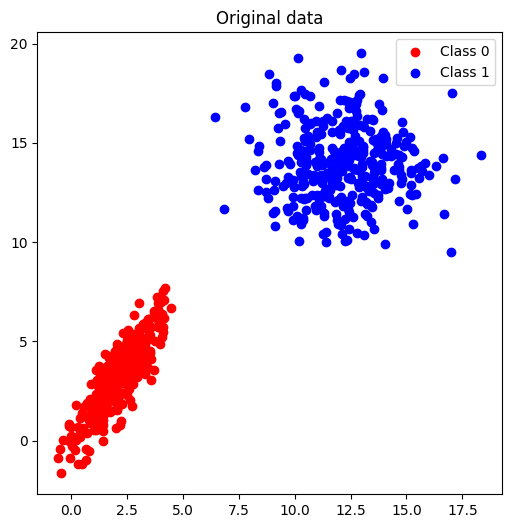

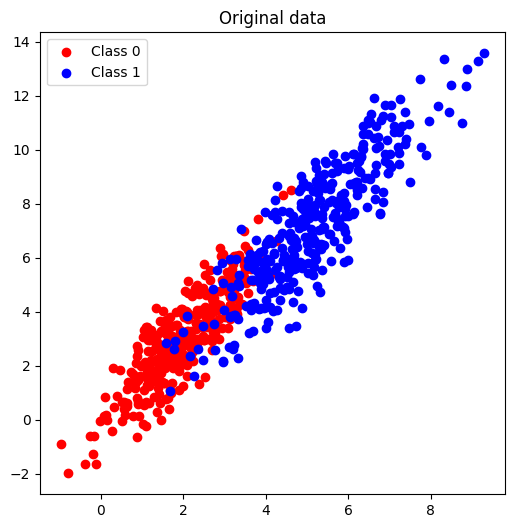

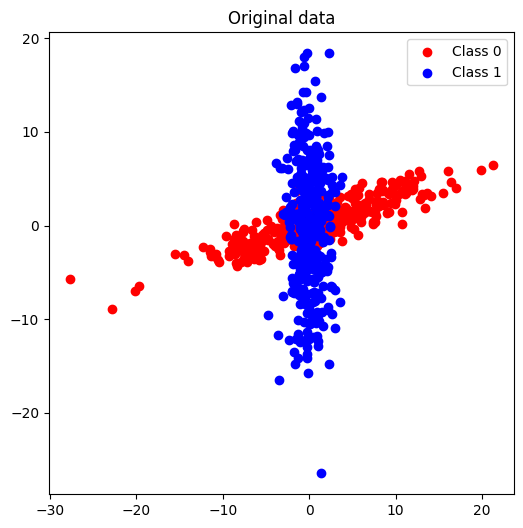

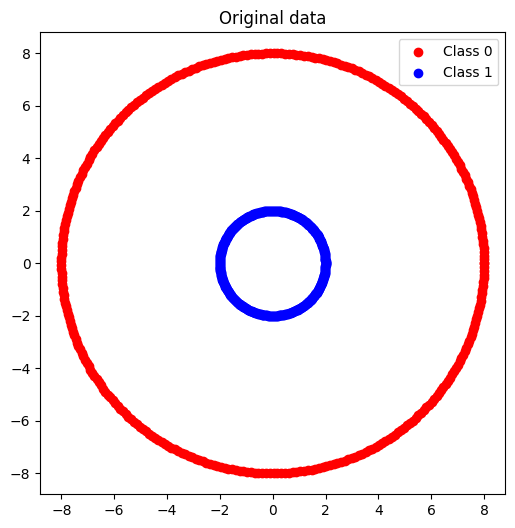

In [4]:
np.random.seed(0)
X01, X11, X1, y1 = plotScenario(1)
X02, X12, X2, y2 = plotScenario(2)
X03, X13, X3, y3 = plotScenario(3)
X04, X14, X4, y4 = plotScenario(4)

## I - 2) PCA

**BASIC PCA**

It's time to start using the methods seen in class. Let's start with PCA. 


As you can see, we have generated two populations (class 0 and class 1). We concatenate them as a single matrix *X* which will be the input for all methods. In this way, the methods will be unaware of the class of the observations (unsupervised) and we will test whether the methods are appropriate for the analysed scenario and if they are able to use less dimensions to correctly distinguish the two classes. 


**Question:**
1. Use PCA with the different 4 scenarios and comment the results. When does PCA work well ? Why ? Explain.

**Answer:** 

PCA works very well on scenario 1, in which the data is linearly separable. The data is separable when projected along the direction that maximizes the variance, therefore it is possible to use only the first principal component to distinguish between the two classes. 

On scenario 2, there is still a direction of projection that retains most of the original variability of the data (97% of the variability), therefore we could use only the first principal component. However there is an overlap between the classes, so some samples will be misclassified.

On scenario 3, we observe, visually, that the two directions of largest variance are not orthogonal, therefore they can't be correctly identified through PCA. Thus, it does not work well on this scenario.

Finally, on scenario 4, we see that all directions of projection yield the same variance, furthermore, the classes aren't linearly separable, neither do they follow Gaussian distributions, for those reasons PCA doesn't work well on this scenario.

In [5]:
def applyPCA( X0, X1, X, y ):

  ## PCA
  pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
  Ypca=pca.fit_transform(X)
  U=pca.components_.T # we want PC on columns
  D = (pca.singular_values_)**2/(X.shape[0]-1) # computation of the eigenvalues

  print('The variance explained by the two first modes is respectively: ', pca.explained_variance_ratio_)
  plotResults(X0,X1,y,U,Ypca,const=1,title='PCA')

The variance explained by the two first modes is respectively:  [0.96586637 0.03413363]


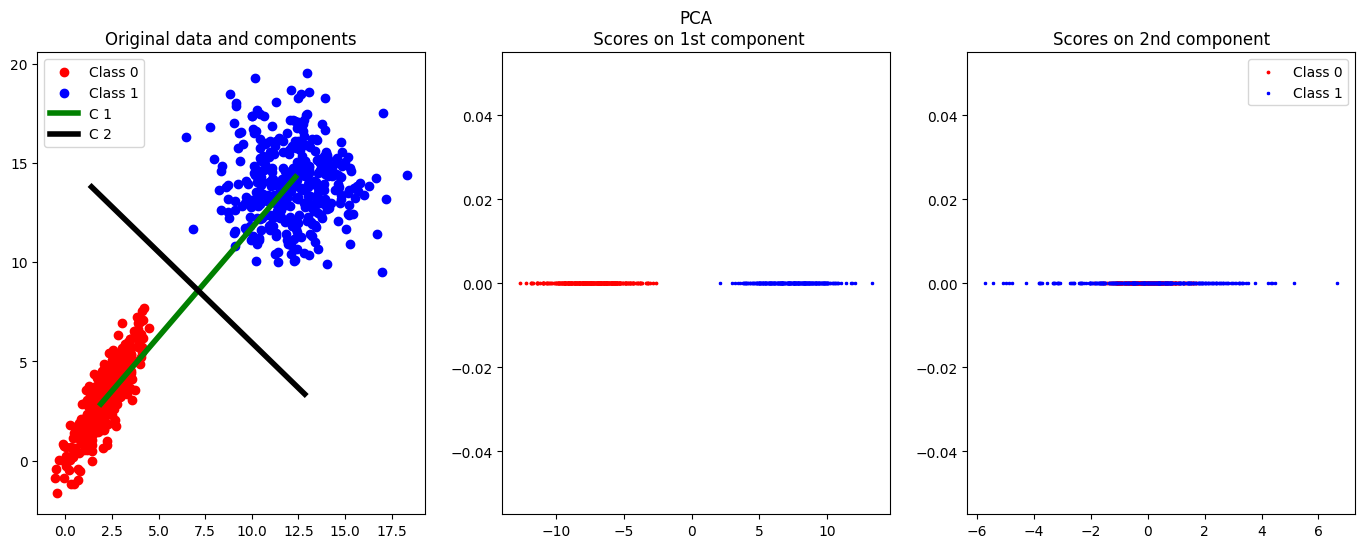

The variance explained by the two first modes is respectively:  [0.97301485 0.02698515]


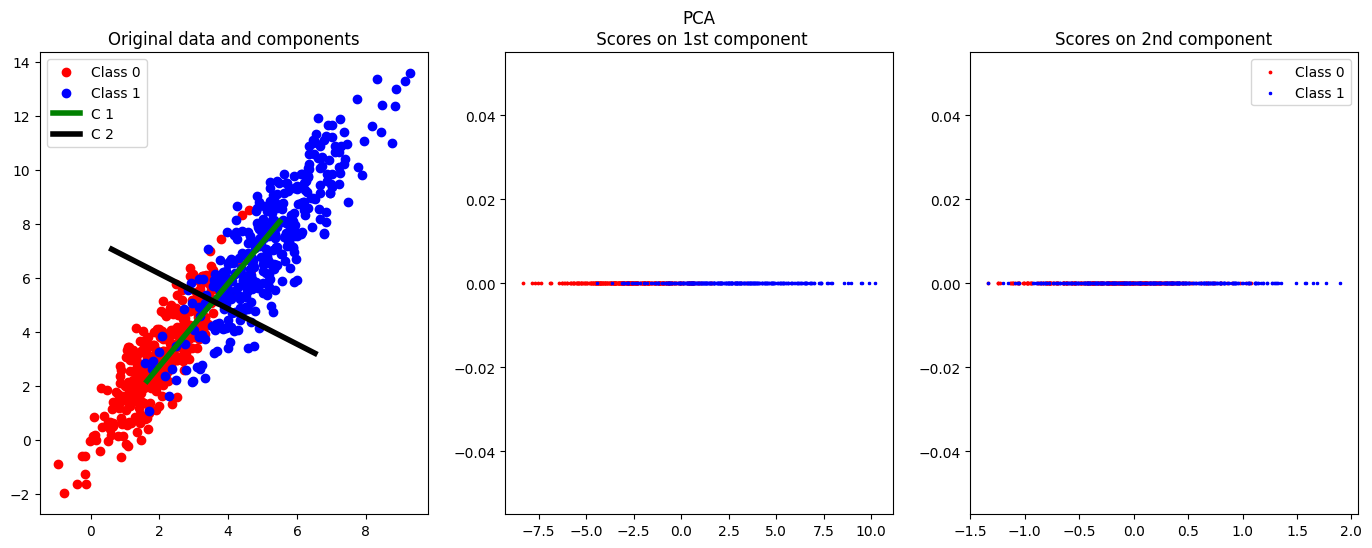

The variance explained by the two first modes is respectively:  [0.63653831 0.36346169]


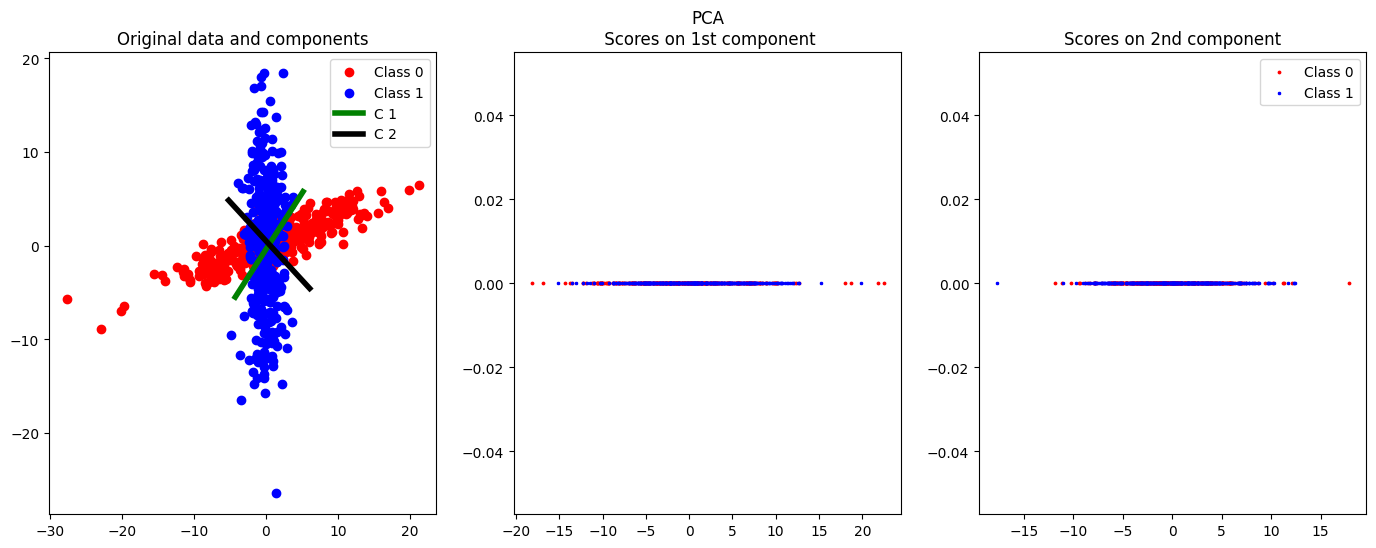

The variance explained by the two first modes is respectively:  [0.50142558 0.49857442]


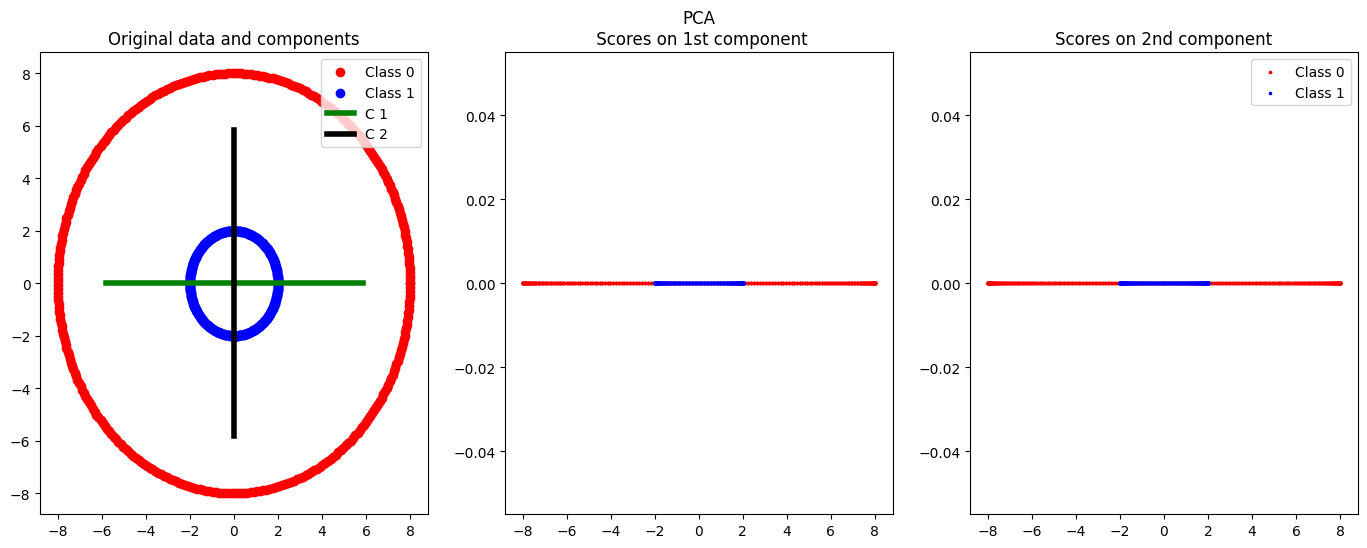

In [6]:
applyPCA(X01, X11, X1, y1)
applyPCA(X02, X12, X2, y2)
applyPCA(X03, X13, X3, y3)
applyPCA(X04, X14, X4, y4)

**Question:**
1. Instead than using the scikit-learn implementation, implement one on your own ! Complete the code where you see **XXXXXXXXXXXXXX**

In [7]:
def pcaLecture(X):
    ''' 
    Inputs: 
            X: is a [Nxd] matrix. Every row is an observation and every
              column consists of features.
    Outputs:
            Y: is a [Nxd] matrix representing the scores, namely the 
            coordinates of X onto the new basis given by the eigenvectors U
            of the covariance matrix of X. Columns are the principal components.
               
            U: columns are Eigenvectors (sorted from the greatest to the lowest eigenvalue)
    
            D: Eigenvalues (sorted from the greatest to the lowest eigenvalue)
               
            var_explained: percentage of the original variability explained
            by each principal component.
    '''
    
    N = X.shape[0]

    Xc = X-np.mean(X, axis=0) # Xc=XXXXXXXXXXX # centering

    _, D2, Uh = LA.svd( Xc ) # D2, Uh = XXXXXXXXXXX # computation of eigenvectors and eigenvalues using SVD
    # D2: singular values in non-increasing order
    # Uh: right singular values as rows
    U = Uh.T # U=XXXXXXXXXXX
    Y = Xc @ U # Y=XXXXXXXXXXX # computation of the scores

    D = D2**2/(N-1) # computation of the eigenvalues
    tot=np.sum(D)
    var_explained = D/tot # var_explained = XXXXXXXXXXX # computation of explained variance

    return Y,U,D,var_explained

**Question:**
1. Test your own implementation and check whether the results are the same of the scikit-learn implementation

**Answer:** The results are the same as those of the scikit-learn implementation.

In [8]:
def applyMyPCA( X0, X1, X, y ):
  YpcaLec,UpcaLec,DpcaLec,var_explainedPcaLec=pcaLecture(X)

  print('The variance explained by the two first modes is respectively: ', var_explainedPcaLec)
  plotResults(X0,X1,y,UpcaLec,YpcaLec,const=1,title='PCA Lecture')

The variance explained by the two first modes is respectively:  [0.96586637 0.03413363]


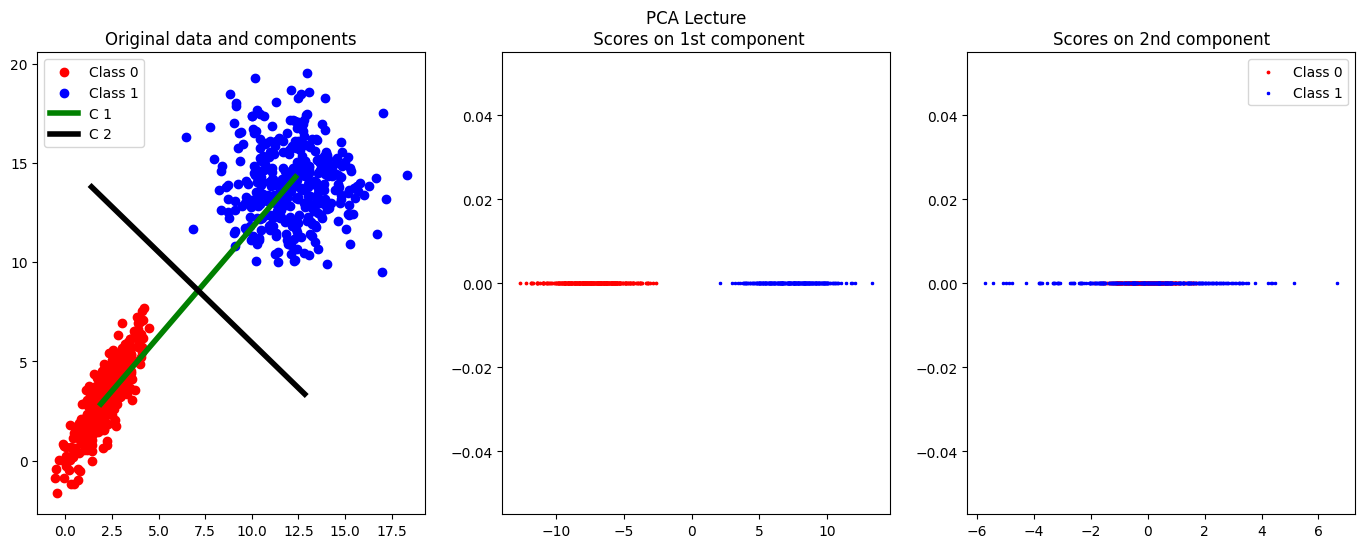

The variance explained by the two first modes is respectively:  [0.97301485 0.02698515]


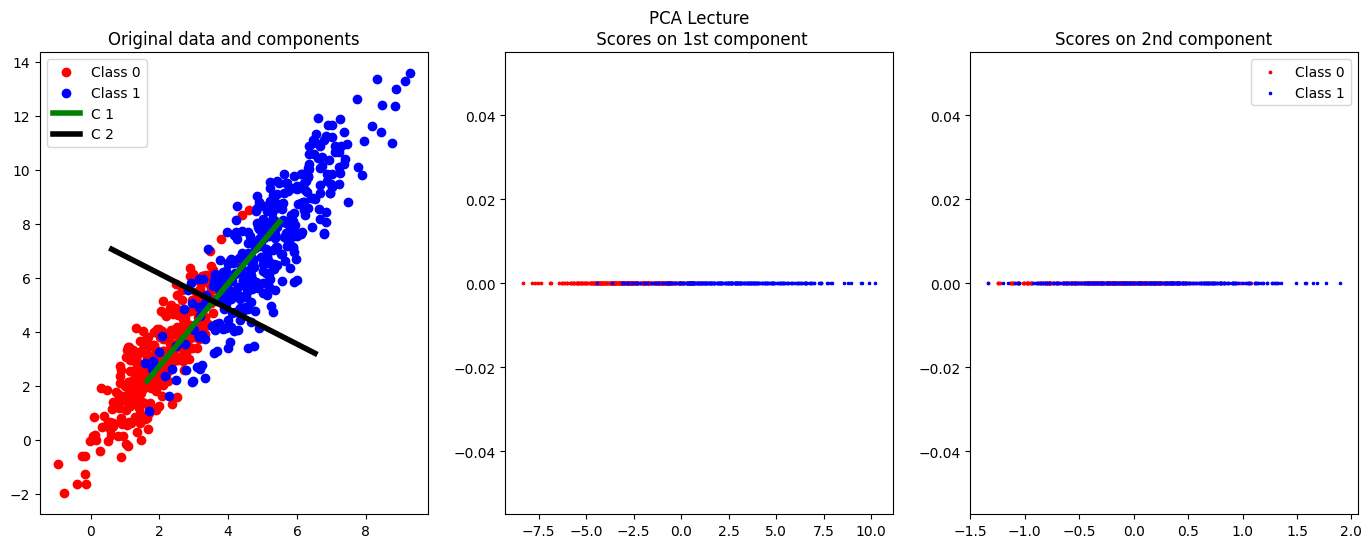

The variance explained by the two first modes is respectively:  [0.63653831 0.36346169]


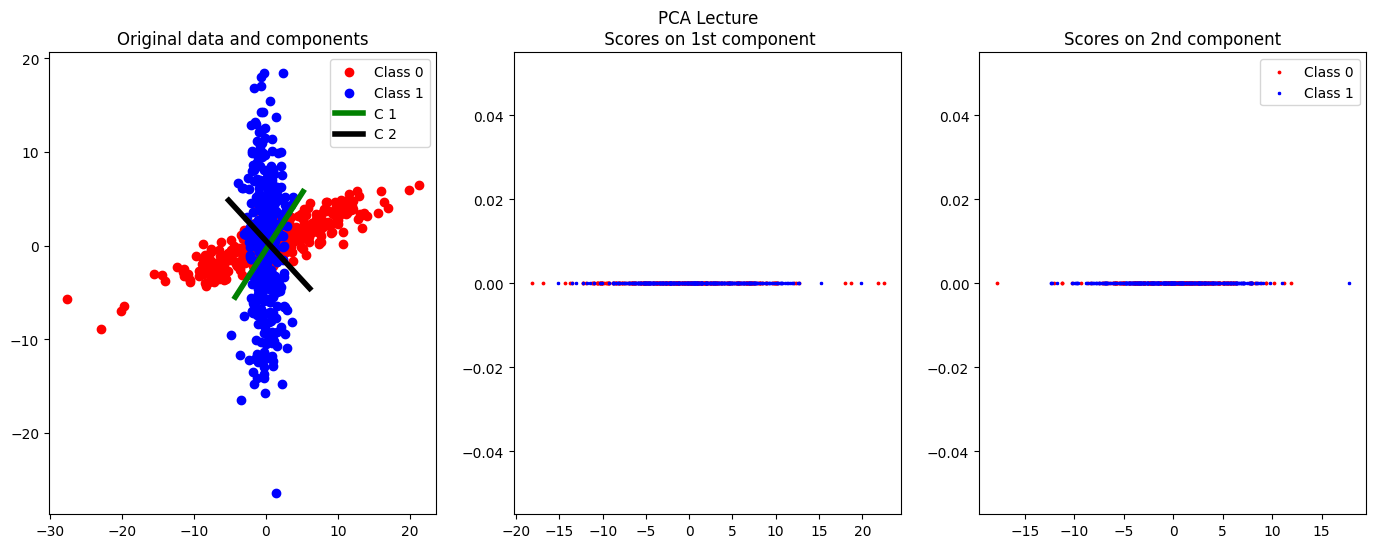

The variance explained by the two first modes is respectively:  [0.50142558 0.49857442]


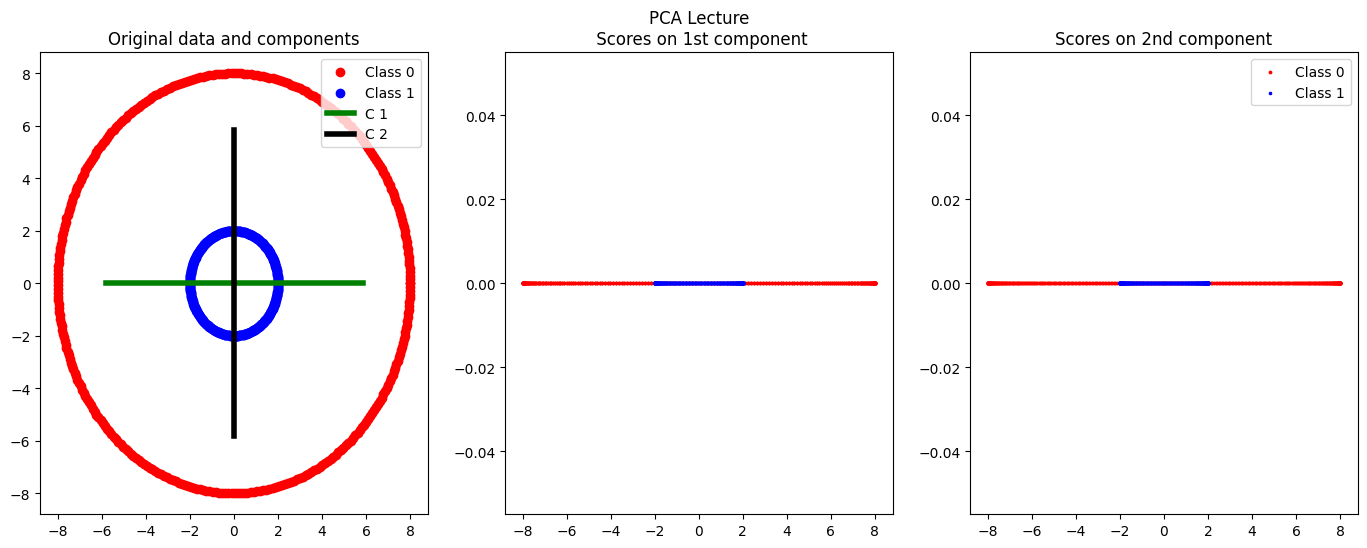

In [9]:
applyMyPCA(X01, X11, X1, y1)
applyMyPCA(X02, X12, X2, y2)
applyMyPCA(X03, X13, X3, y3)
applyMyPCA(X04, X14, X4, y4)

**KERNEL PCA**

Let's now use Kernel-PCA with the rbf kernel (you can also test other kernels if you want).

**Question:**
1. What is the interest of kernel PCA over the basic PCA?
2. Use Kernel-PCA with the different 4 scenarios and comment the results. When does K-PCA work well ? Why ?

**Answer:**

1. The interest of kernel PCA over the basic PCA is that, when the data isn't linearly separable, by mapping it into a higher dimensional space, the classes might become separable.

2. For scenario 1, K-PCA still finds a principal component for which the data is separable. For scenarios 2 and 3 K-PCA doesn't work well. Scenario 4 is the one for which K-PCA works best, succeeding in separating the data with a single principle component, this is the case because the mapping function that corresponds to the rbf kernel involves the norm of the data sample, therefore, by mapping the data into a higher dimensional space, it is able to separate the concentric circles of different radius (the value of $\gamma$ had to be ajusted).

In [10]:
def applyKernelPCA( X0, X1, X, y, gamma=1/8 ):

  Kpca = KernelPCA(kernel='rbf', gamma=gamma, random_state=1)
  YKpca=Kpca.fit_transform(X)
  DKpca=Kpca.eigenvalues_
  AKpca=Kpca.eigenvectors_

  plotResults(X0=X0,X1=X1,y=y,Y=YKpca,const=1,title='KPCA')

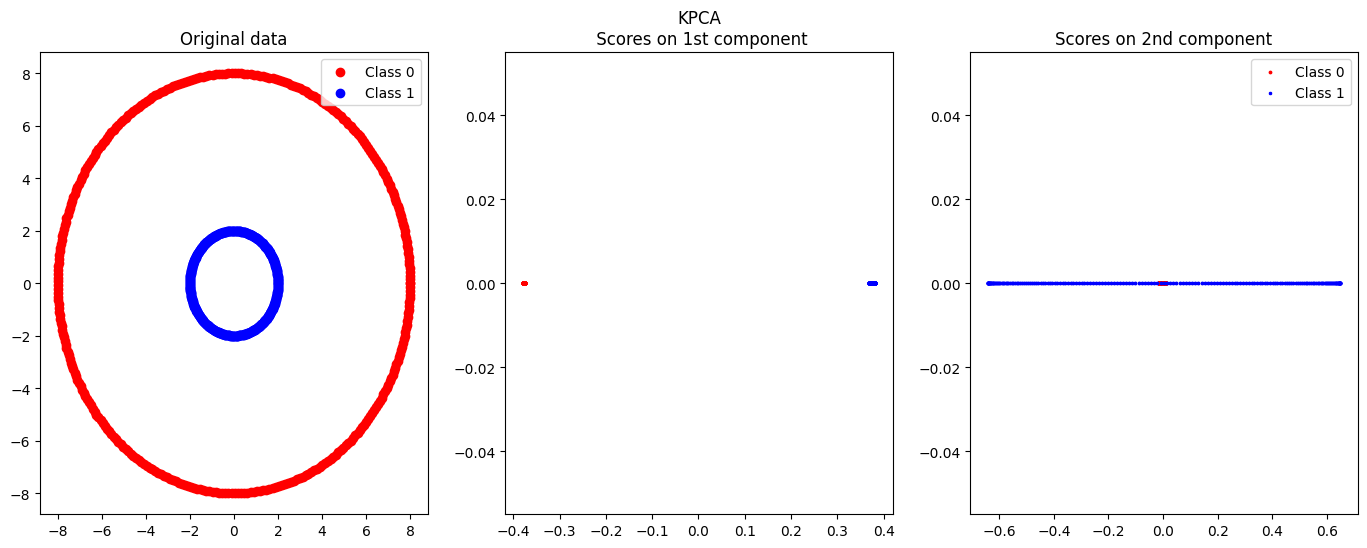

In [11]:
applyKernelPCA(X04, X14, X4, y4)

**Question:**
1. Instead than using the scikit-learn implementation, implement one on your own ! Complete the code where you see **XXXXXXXXXXXXXX**

In [12]:
def KpcaGaussianLecture(X,gamma):
    '''  
    Inputs: 
            X: is a [Nxd] matrix. Every row is an observation and every
            column is a feature.
 
    Outputs:
            Y: is a [Nxd] matrix representing the scores, namely the 
            coordinates of \phi(X) onto the new basis given by the eigenvactors 
            of the covariance matrix of \phi(X). Columns are the principal components.

            An: columns are Eigenvectors normalised (sorted from the greatest
            to the lowest eigenvalue)
     
            D: Eigenvalues (sorted from the greatest to the lowest eigenvalue)

            var_explained: percentage of the original variability explained
            by each principal component.

    '''

    # kernel matrix using a rbf kernel 
    def kernel_matrix(X,gamma):
      N=X.shape[0]
      InnerX = np.dot(X,X.T)
      temp1=np.sum(X**2,axis=1).reshape((N,1))
      temp2=np.sum(X**2,axis=1).reshape((1,N))
      Norm1 = np.repeat(temp1,N,axis=1)
      Norm2 = np.repeat(temp2,N,axis=0) 
      Norm = Norm1+Norm2-2*InnerX;
      Norm[Norm<1e-10]=0;    
      K=np.exp(-Norm/(2*gamma**2))
      return K
       
    N=X.shape[0]

    K=kernel_matrix(X, gamma) # K=XXXXXXXXXXX
    
    # center kernel matrix
    oneN=np.ones((N,N))/N;
    Kc = K - oneN@K - K@oneN + oneN@K@oneN # Kc=XXXXXXXXXXX # center kernel matrix

    # eigenvalue analysis
    D,A=LA.eigh(Kc)     
    idx = D.argsort()[::-1]  # reverse order to make 'descend' 
    D = np.real(D[idx])
    D[D<0]=1e-18 # make negative eigenvalues positive (and almost 0)
    A = np.real(A[:,idx])

    # variance explained
    tot=np.sum(D)
    var_explained = D/tot # var_explained = XXXXXXXXXXX # computation of explained variance

    # Normalisation eigenvectors
    # Norm of every eigenvector is 1, we want it to be 1/sqrt(N*eig)
    
    An=np.copy(A)
    for i in range(N):      
        An[:,i]=np.dot(A[:,i],(1/np.sqrt((N-1)*D[i])) )          
           
    Y = K@An # Y=XXXXXXXXXXX # computation of the scores  
    
    return Y,An,D,var_explained


Test your own implementation

In [13]:
def applyMyKernelPCA( X0, X1, X, y, gamma=2 ):
  
  YKpcaLec, AnKpcaLec, DKpcaLec, var_explainedKpca = KpcaGaussianLecture(X,gamma)
  plotResults(X0=X0,X1=X1,y=y,Y=YKpcaLec,const=1,title='KPCA Lecture')

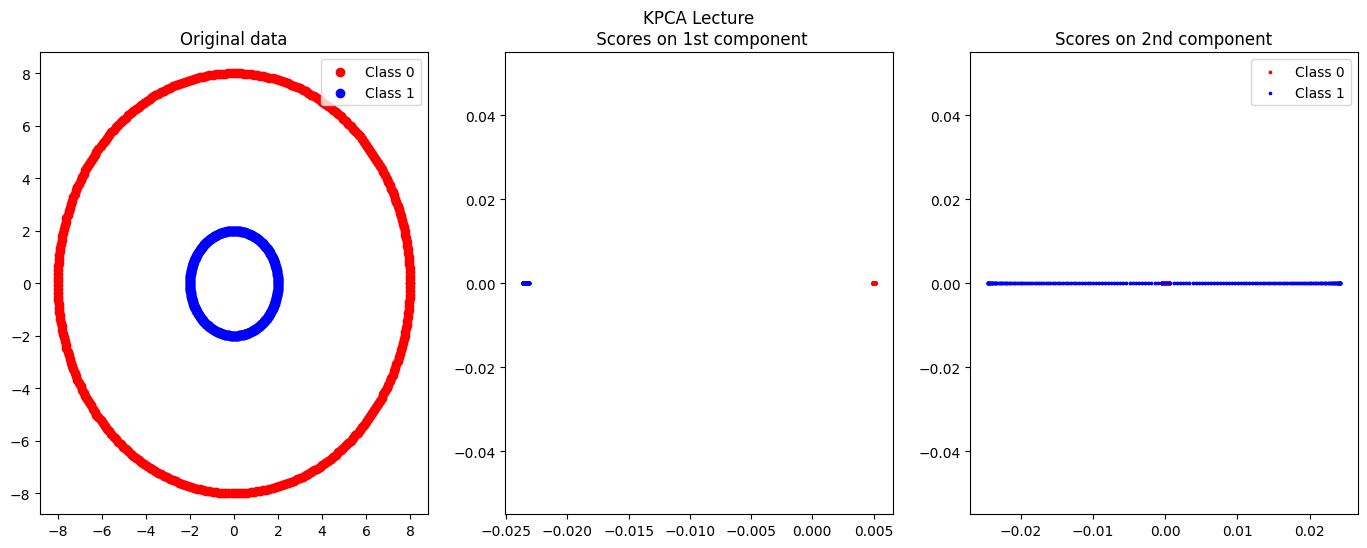

In [14]:
applyMyKernelPCA(X04, X14, X4, y4)

## I - 3) ICA

Now, we work on ICA, first by testing scickit-learn FastICA implementation, and then coding your own.

**Question:**
1. Use ICA with the different 4 scenarios and comment the results. When it works better than PCA ? Why ?

Comparing the results of ICA with those of PCA, we see that it works better on scenario 3, where there are two directions of largest variance that are not orthogonal. In this case, ICA correctly identifies those two directions, while PCA does not due to the orthogonality constraint.

In [15]:
def applyICA( X0, X1, X, y ):

  ICA= FastICA(whiten=True, fun='exp', max_iter=20000, tol=0.00001, random_state=1)
  Yica=ICA.fit_transform(X)
  Wica=ICA.mixing_
  plotResults(X0=X0,X1=X1,y=y,U=Wica,Y=Yica,const=0.01,title='ICA')

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:708: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit_transform(X, compute_sources=True)
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


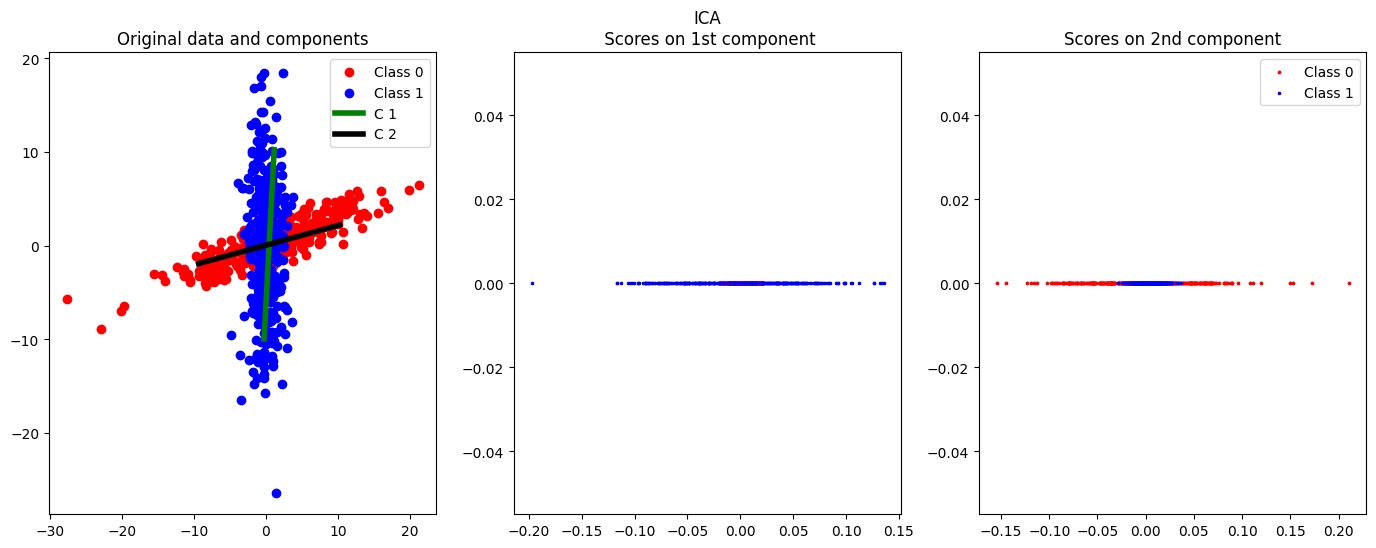

In [16]:
applyICA(X03, X13, X3, y3)

**Question:**
1. Instead than using the scikit-learn implementation, implement one on your own !
Complete the code where you see **XXXXXXXXXXXXXX**

In [17]:
def FastICALecture(X,N_Iter=3000,tol=1e-5,plot_evolution=0):
    '''
    Inputs: 
                   X: is a [d x N] matrix. Every column is an observation 
                   and every row is a feature.       
    
                   (Optional) N_Iter: maximum number of iterations
    
                   (Optional) delta: convergence criteria threshold
    
                   (Optional) plot_evolution: plot evolution of error
                   
     Outputs:      
                   S: [d x N] matrix.  Each column is an independent component 
                   of the centred and whitened input data X              
                   
                   W: [d x d] matrix. It is the demixing matrix. S = W*Xcw 
    
    '''
    
    # We choose G=-exp(-1/2t^2)
    # First derivative of G   
    def g(t):
        res = t*np.exp(-(t**2)/2)
        return res
    
    # Second derivative of G  
    def gp(t):
        res = (1-(t**2))*np.exp(-(t**2)/2)
        return res
    
    # Size of X
    d,N=X.shape 
        
    # Compute sample mean
    mu = np.mean(X, axis=1, keepdims=True)

    # Center data
    Xc=X-mu
    
    # Compute covariance matrix
    C=np.cov(X)
    
    # Whiten data
    Xcw=LA.sqrtm(LA.inv(C))@Xc
    
    # check if are whitened
    if np.sum(np.eye(d) - np.abs(np.cov(Xcw)))>1e-10:
        raise NameError('Your whitening transformation does not work...')
    
    # Initialize W
    W = ortho_group.rvs(d) # random orthogonal matrix 
    
    # delta evolution
    k = 0
    delta = np.inf
    evolutionDelta=[]
    
    while delta > tol and k < N_Iter:
    
        k = k + 1
        W_old = np.copy(W)
        
        Wp = g(W@Xcw)@Xcw.T - np.diag( (gp(W@Xcw)@np.ones((N,1))).reshape(-1) )@W
        W = LA.sqrtm( LA.inv(Wp@Wp.T) )@Wp
        if np.sum(np.eye(d)-np.abs(np.dot(W,W.T)))>1e-10:
            raise NameError('W should be an orthogonal matrix. Check the computations')
                 
        delta = 1-np.min(np.abs(np.diag(np.dot(W.T,W_old))))
        evolutionDelta.append(delta)
        
        if k==1 or k%100==0:
            print('Iteration ICA number ', k, ' out of ', N_Iter , ', delta = ', delta)
     
        
    if k==N_Iter:
        print('Maximum number of iterations reached ! delta = ', delta)
    else:
        print('Convergence achieved ( delta = ', delta, ') in ', k, ' iterations')


    # Independent components
    S = W@X

            
    if plot_evolution==1:
        plt.figure(figsize=(6, 6))
        plt.plot(range(k),evolutionDelta,'bx--', linewidth=4, markersize=12)  
        plt.title('Evolution of error - ICA')
        plt.show()
       
    return S,W,Xcw


Test your own implementation

In [18]:
def applyMyICA(X0, X1, X, y):
  
  SicaLec,WicaLec,Xwh = FastICALecture(X.T,N_Iter=3000,tol=1e-5,plot_evolution=1)
  plotResults(X0=X0,X1=X1,y=y, U=WicaLec.T, Y=SicaLec.T, const=1, title='ICA Lecture')

Iteration ICA number  1  out of  3000 , delta =  0.11785519253227439
Iteration ICA number  100  out of  3000 , delta =  0.017425396630264878
Iteration ICA number  200  out of  3000 , delta =  0.007862411704281702
Iteration ICA number  300  out of  3000 , delta =  0.004536624732308647
Iteration ICA number  400  out of  3000 , delta =  0.002904893478897441
Iteration ICA number  500  out of  3000 , delta =  0.0019669126068816434
Iteration ICA number  600  out of  3000 , delta =  0.0013775190762801426
Iteration ICA number  700  out of  3000 , delta =  0.0009860757167935441
Iteration ICA number  800  out of  3000 , delta =  0.000716411583776333
Iteration ICA number  900  out of  3000 , delta =  0.0005259129545400754
Iteration ICA number  1000  out of  3000 , delta =  0.0003889330798693136
Iteration ICA number  1100  out of  3000 , delta =  0.00028917472445055825
Iteration ICA number  1200  out of  3000 , delta =  0.00021584766564464175
Iteration ICA number  1300  out of  3000 , delta =  0.0

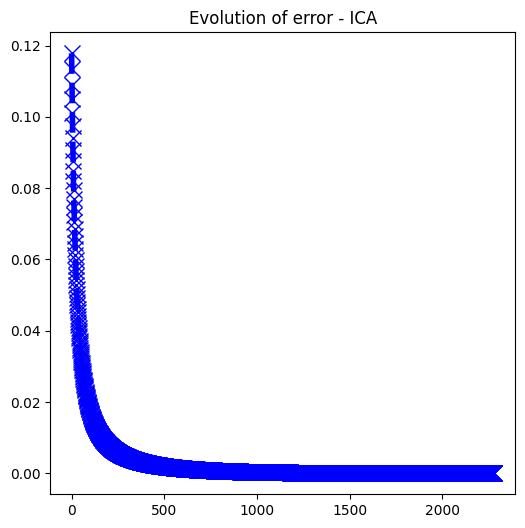

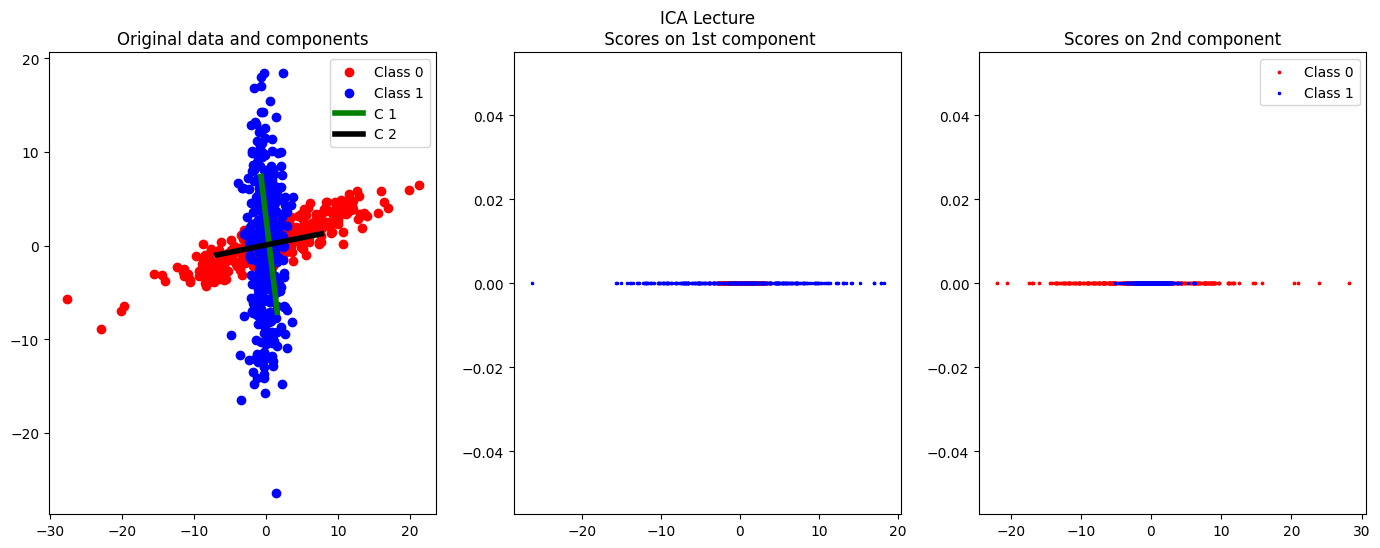

In [19]:
applyMyICA(X03, X13, X3, y3)

# II - True image dataset and face recognition
## II - 1) Dataset

**Goal**
The goal of this part is to evaluate the performance of the dimensionality reduction techniques presented this morning as a preprocessing for face recognition. We divide the data-set into two parts, training and test. For every dimensionality reduction technique, you will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm to evaluate the performance of the dimensionality reduction technique. 

Load the original images present in the files *'YaleB\_32x32.mat'*. This is a small part of the freely available Extended Yale Face Database B downloaded from http://www.cad.zju.edu.cn/home/dengcai/Data/FaceData.html. It contains 2414 cropped images resized to 32x32 pixels. Every image is represented as a vector 1x1024 and all images are stacked in a matrix called data. There are 38 subjects with around 64 near frontal images per individual under different illumination conditions. Once loaded and normalised the data, such that the pixels are between 0 and 1, you can plot images using the function *'imshow'*.

Let's load the data.

In [ ]:
if 'google.colab' in str(get_ipython()):
  # from google_drive_downloader import GoogleDriveDownloader as gdd
  # gdd.download_file_from_google_drive(file_id='1rgICXtcIAgDqSoHnNXNZMD_iNABF3RZA',
  # dest_path='./YaleB_32x32.mat')
  from google.colab import drive
  drive.mount('/content/drive')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
Working_directory="./drive/MyDrive/2022-2A/IMA205/"


Below is a useful function to plot the basis images. Be careful, each row of data is a basis image.

In [ ]:
def plotFaces(data,r,c,ncol=2,N=0,indeces=None,title=None):
    # data: each face is a row in data
    # r,c = number of rows and columns of each image
    # n_col = number of columns for subplots
    # N = random images to plot (used only if indeces is empty)
    # indeces = indeces of images to plot
    # title = title of the plot

   
    if indeces is None:
        if N==0:
            raise NameError('You should define either N or indeces')
        else:
            print('Use N random subjects')
            indeces=np.random.randint(0,data.shape[0],(N,1))
            
    nrow=math.ceil(len(indeces)/ncol)
    
    fig=plt.figure(figsize=(17, 6))
    plt.suptitle(title, size=16)
    for i, index in enumerate(indeces):
        fig.add_subplot(nrow, ncol, i+1)
        plt.imshow(np.resize(data[index,:],(r,c)).T,origin='upper',cmap='gray')
        plt.xticks(())
        plt.yticks(())
  

Let's load the data and compute some parameters.

In [ ]:
x = loadmat(Working_directory + './YaleB_32x32.mat')
data=x['fea']
d=data.shape[1] # number of pixels of the images
subjectIndex=x['gnd'] # we have one index per subject
maxValue = np.max(np.max(data)) # max intensity value
data = data/maxValue; # Scale pixels to [0,1]

Ns=len(np.unique(subjectIndex)); # Number subjects
Is=round(len(subjectIndex)/Ns) # Number images per subject (on average, not the same number for every subject)
r=int(np.sqrt(d)) # number rows of each image
c=r # number columns of each image, equal to row since images are square

print('There are', data.shape[0], 'facial images and each image has', d, 'pixels' )
print('There are', Ns, 'different subjects and each subject has on average', Is, 'images')

In [ ]:
data.shape

Let's plot first 10 images of different subjects and then 10 images of the same subject but with different positions and illumination conditions

In [ ]:
# Plot data      
indexDifferent=np.arange(1,Is*40,Is)     
plotFaces(data,r,c,ncol=3,indeces=indexDifferent[0:10],title='Different subjects')       
indexSame=np.arange(0,10,1)      
plotFaces(data,r,c,ncol=2,indeces=indexSame,title='Different positions of the same subjects')       


We can now move to evaluate the  performance of the dimensionality reduction techniques presented this morning for face recognition. We first divide the data-set into two parts, training (80%) and test (20%) in a stratified way (subjects are divided in a balanced way between the two parts).

We will see in the next lecture why we need to divide into training and test sets. For now, just know that we will use the first set to train our algorithm and the second set to test the performance of our algorithm on new, unseen data.



In [ ]:
Xtrain, Xtest, Id_Train, Id_Test = train_test_split(data,subjectIndex,test_size=0.20,stratify=subjectIndex, random_state=44)
Xctest = Xtest - np.mean(Xtest, axis=0) # centering
Xctrain = Xtrain - np.mean(Xtrain, axis=0) # centering

As first idea, we could simply use the pixel intensities as features for the classification. This is basically like using the original data, without dimensionality reducton techniques.
In the following, we will use the nearest-neighboor algorithm to perform the classification task. For each test sample, the nearest neighbor algorithm simply looks for the closest training sample and then assigns the same label (i.e. index of subject).

In [ ]:
## Use the pixel intensities to find the correct subject for the test images
NN=KNeighborsClassifier(n_neighbors=1)
NN.fit(Xctrain,Id_Train.ravel())
print('By using the pixel intensities, we use ', Xctrain.shape[1], ' features')
print('Percentage of correct answer using the pixel intensities is ', NN.score(Xctest,Id_Test))

# II - 2) PCA
**Preliminary part:** We can use PCA to investigate the main variations within the data.

**Question:**
1. How many modes do you need to explain at least 80% of the variability in the data ? 
2. Look at the three main modes and explain which are the main variations in the data.

**Answers:**
1. To explain at least 80% of the variability of the data, we need 5 modes.

2. For the first mode, the main variation is the intensity of the light. For the second mode, the main variation is the direction of illumination, with the position of the light source varying from right to left. And, for the third mode, the main variation is the contrast between the different features of the face, which also could be interpreted as a variation in the direction of illumination, varying from downwards to upwards.

In [ ]:
# Linear interpolation along the first two modes
Xm=data.mean(axis=0) # average face
YpcaTrain,UpcaTrain,DpcaTrain,var_explained_pca=pcaLecture(data)
indices=np.linspace(-3, 3, num=7, dtype=np.int16) # Interpolation indices

# Variance explained by each eigenvector
fig=plt.figure(figsize=(7, 7))
ax=plt.subplot(111)
ax.set_xlim(0, 9)
dim=np.arange(0,10,1)
plt.plot( 100*np.cumsum(var_explained_pca)/np.sum(var_explained_pca) )
plt.xticks(dim)
plt.xlabel('Number of eigenvectors',fontsize=15)
plt.ylabel('% variance explained',fontsize=15)
plt.title('Variance explained by PCA modes',fontsize=17)

## First mode
fig=plt.figure(figsize=(17, 3))
plt.suptitle('Variations along the first mode of PCA', size=20)
for i, index in enumerate(indices):
  image = Xm + index*np.sqrt(DpcaTrain[0])*UpcaTrain[:,0]
  fig.add_subplot(1, len(indices), i+1)
  plt.imshow(np.resize(image,(r,c)).T,origin='upper',cmap='gray')
  if index != 0:
    plt.xlabel(r'%i $\sigma$' %index, fontsize=15)
  else:
    plt.xlabel('Average face', fontsize=15)
  plt.xticks(())
  plt.yticks(())
  plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)


## Second mode
fig=plt.figure(figsize=(17, 3))
plt.suptitle('Variations along the second mode of PCA', size=20)
for i, index in enumerate(indices):
  image = Xm + index*np.sqrt(DpcaTrain[1])*UpcaTrain[:,1]
  fig.add_subplot(1, len(indices), i+1)
  plt.imshow(np.resize(image,(r,c)).T,origin='upper',cmap='gray')
  if index != 0:
    plt.xlabel(r'%i $\sigma$' %index, fontsize=15)
  else:
    plt.xlabel('Average face', fontsize=15)
  plt.xticks(())
  plt.yticks(())
  plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)

## Third mode
fig=plt.figure(figsize=(17, 3))
plt.suptitle('Variations along the third mode of PCA', size=20)
for i, index in enumerate(indices):
  image = Xm + index*np.sqrt(DpcaTrain[2])*UpcaTrain[:,2]
  fig.add_subplot(1, len(indices), i+1)
  plt.imshow(np.resize(image,(r,c)).T,origin='upper',cmap='gray')
  if index != 0:
    plt.xlabel(r'%i $\sigma$' %index, fontsize=15)
  else:
    plt.xlabel('Average face', fontsize=15)
  plt.xticks(())
  plt.yticks(())
  plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)

In [ ]:
cum_var_explained = 100*np.cumsum(var_explained_pca)/np.sum(var_explained_pca)
i = 0
for v in cum_var_explained:
  i += 1
  if v > 80:
    print(i)
    break

**PCA as a preprocessing for classification:**

Now, we can employ PCA as a preprocessing step before classification. You will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm to evaluate the performance of the dimensionality reduction technique. 




Precisely, using PCA, compute the scores $Y_{train}$, eigenvectors $U_{train}$ and eigenvalues $D_{train}$ of the training set. The eigenvectors $U_{train}$ represent the basis images and they are usually called *'Eigenfaces'*. Then, project both training and test data onto the eigenvectors that explain 99 $\%$ of the variability of the training set $L_{train}^{99}$. You will obtain two vectors of scores, $Y_{train}^{99}=X_{train} L_{train}^{99}$ and $Y_{test}^{99}=X_{test} L_{test}^{99}$, which you will use for evaluating the performance of the algorithm. Use the function `KNeighborsClassifier` to test the performance.

**Practical Questions:** 

1. Use the scikit-learn implementation to test the performance, as previously explained. Furthermore, please comment the eigenfaces. Do they seem "real" ?

**Answers:**

Testing the performance as described above, the percentage of correct answers was $71\%$. All of the eigenfaces obtained resemble humam faces, however they do not seem real (perhaps with the exception of the first one), this is the case because they indeed aren't real images, but only the directions that express the variability of the data.

**Theoretical Questions:** 

1. In your opinion, why do we need to center the data before computing a PCA ? If you want, you can use the previous toy examples to answer this question.
2. Let $X$ be the original data, a matrix $\left[ N,d \right]$, and $Y$ the scores of a PCA keeping all eigenvectors, which means that $Y$ is also a matrix $\left[ N,d \right]$. Are $X$ and $Y$ equal ? If not, why ? What would you use (generally speaking) in a machine learning problem ? Why ?
3. Let $x_p$ and $x_q$ be two row-vectors representing two images, $U$ an *orthogonal* matrix whose columns are the eigenvectors of $X$ and $y_p=x_pU$, $y_q=x_qU$, check that $x_px_q^T=y_py_q^T$. This shows that $Y=XU$ is a linear transformation that preserves inner products.
4. Let $C$ be the covariance matrix of $X$ and $C=UDU^T$ its eigen decomposition. Show that the covariance matrix of $Y=XU$ is $D$.


**Answers:**

1. Let $X$ be the data and $X_c$ be the centered data. If by centering the data before computing PCA it is meant performing the eigen-decomposition on the $X_c^TX_c$ matrix instead of the $X^TX$ matrix, then we need to center the data before computing PCA because we are looking for the direction that maximizes the variability of the projected data, which corresponds to searching for the eigenvectors of the covariance matrix, which is exactly $X_c^TX_c/(N-1)$.

2. X and Y are not equal, they are, however, representations of the same data but on different orthogonal basis, Y is obtained from X by a change of basis: $Y=XU$. Therefore, I would use $X$ in a machine learning problem, since both $X$ and $Y$ contain the same information, there is no dimensionality reduction (since we kept all of the principal components) and using $Y$ would entail spending time computing the PCA transformation.

3. To show that $U$ is a linear transformation that preserves inner products, we must show that, $\forall x_p, x_q$:
$$\langle Ux_p, Ux_q \rangle = \langle x_p, x_q \rangle$$
Developing the right hand-side, knowing that $U$ is orthogonal:
$$\langle Ux_p, Ux_q \rangle = \left( Ux_p \right)^T \left( Ux_q \right) = x_p^TU^TUx_q = x_p^T x_q$$
and, by definition:
$$\langle Ux_p, Ux_q \rangle = \langle y_p, y_q \rangle  = y_p^Ty_q$$
so:
$$x_p^T x_q = y_p^Ty_q$$
 
4. If $Y=XU$, then the covariance matrix of $Y$ is:
$$C_Y = \frac{1}{N-1}Y_c^TY_c$$
where the centered data $Y_c$ can be expressed as:
$$Y_c = Y - \frac{1}{N} 1_N 1_N^T Y = \left(I - \frac{1}{N} 1_N 1_N^T\right)Y := WY$$
substituting on the expression for $C_Y$:
$$\begin{aligned}
C_Y &= \frac{1}{N-1}\left( WY \right)^T \left( WY \right)\\
&= \frac{1}{N-1} Y^T W^T W Y\\
&= \frac{1}{N-1} U^T X^T W^T W X U\\
&= U^T \left( \frac{1}{N-1} \left(WX\right)^T W X \right) U\\
&= U^T \left( \frac{1}{N-1} X_c^T X_c \right) U\\ 
&= U^T C U\\ 
&= U^T U D U^T U\\
&= D 
\end{aligned}$$
where in the last equality the fact that $U$ is orthogonal was used.

In [ ]:
## PCA (scikit-learn implementation)
pca = PCA(random_state=1) 
Ytrain = pca.fit_transform(Xctrain)
U = pca.components_.T # eigenvectors on columns
D = (pca.singular_values_)**2/(Xctrain.shape[0]-1) # computation of the eigenvalues

# Threshold defined as 99% of the variability
PCAComp = -1
cum_explained = np.cumsum(pca.explained_variance_ratio_)/np.sum(pca.explained_variance_ratio_)
for i, v in enumerate(cum_explained):
  if v > 0.99:
    PCAComp = i+1
    break

print('PCA uses ', PCAComp, ' features')

# Selection of the eigenvectors 
L99 = U[:,0:PCAComp]
D99 = D[0:PCAComp]

# Computation of the test scores using the eigenvectors computed with the
# training data-set
Ytrain99 = Xctrain@L99
Ytest99 = Xctest@L99

# Plot the Eigenfaces
plotFaces(U.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='PCA - Eigenfaces')       

# Score: apply the nearest-neighboor algorithm to PCA output
NN=KNeighborsClassifier(n_neighbors=1)
NN.fit(Ytrain99,Id_Train.ravel())
print('Percentage of correct answer using PCA is ', NN.score(Ytest99,Id_Test))

In [ ]:
np.sum( np.abs(Ytrain - Xctrain@U) )

**KPCA**

In this section, we are going to do exactly the same procedure as before but using Kernel-PCA with a Gaussian kernel. Remember that we need to compute and center the test kernel matrix $[\mathbf{\tilde{K}}]_{ij}=<\phi(x_i)-\frac{1}{N} \sum_{s=1}^N \phi(x_s),\phi(x_j)-\frac{1}{N} \sum_{s=1}^N \phi(x_s)>$ and that, once computed the basis vectors in the training set $\{  \mathbf{\alpha}_i \}$, we can compute the score for a test sample $t$ using the following equation:

$y_i(t) = \sum_{j=1}^N a_{ij} <\phi(t)-\frac{1}{N} \sum_{s=1}^N \phi(x_s),\phi(x_j)-\frac{1}{N} \sum_{s=1}^N \phi(x_s)> = \sum_{j=1}^N a_{ij} \tilde{k}(t,x_j)$

Answer the following questions:

**Questions:** 

1. Use the scikit-learn implementation to test the performance
2. Look for the best gamma value
3. Why the basis vectors $\{  \mathbf{\alpha}_i \}$ are not plotted as in PCA ?
4. Is it worth it, in your opinion, to compute PCA and/or KPCA ? Why not using the original pixel intensities ? Please consider the following aspects in your answer: performance, computational time, number of features, and interpretability of the results.
5. (Optional) Create a new function `Kpca_poly_lecture` where you change the kernel to $k(x,y)=<x,y>^d$. Evaluate the performance of this new kernel.

**Answers:**

1. Implemented bellow.

2. The best gamma value was $\gamma = 3.4$, with a test performance of $64.8\%$.

3. The basis vectors are not plotted as in PCA because we are projecting the data into a higher dimensional space, therefore plotting them as images has no visual interest anymore.

4. In my opinion, in this case, it is worth computing PCA. Because although using the original pixel intensities yielded the best performance, of $74\%$, by using PCA there was a significant decrease in the number of features, we went from 1024 to 233 features, and there wasn't much loss in performance, which was of $71\%$. Therefore there is a significant decrease in the computational cost of running KNN, furthermore the results can be easily interpreted as we can plot the eigenvectors as images. On the other hand, I wouldn't choose K-PCA with a Gaussian Kernel because the number of features used increased, therefore so does the computational cost of applying KNN, and the performance was significantly worse. Furthermore the results aren't easily interpretable since we are projecting the data into a higher dimensional space.

In [ ]:
# for gamma in np.logspace(-1,1,10):
# for gamma in np.linspace(1,10,10):
for gamma in np.linspace(3,4,10):
    # gamma = 4
    Kpca = KernelPCA(kernel='rbf', gamma=gamma, random_state=1)
    Ytrain = Kpca.fit_transform(Xctrain)
    DKpca = Kpca.eigenvalues_
    U = Kpca.eigenvectors_ # eigenvectors on columns

    # variance explained
    var_explained = DKpca/np.sum(DKpca)

    # Threshold defined as 99% of the variability
    KpcaComp = -1
    cum_explained = np.cumsum(var_explained)
    for i, v in enumerate(cum_explained):
        if v > 0.99:
            KpcaComp = i+1
            break

    print('KPCA uses ', KpcaComp, ' features')

    # Ytest = Kpca.transform(Xctest)
    # Ytrain99 = Ytrain[:,:KpcaComp]
    # Ytest99 = Ytest[:,:KpcaComp]

    # Selection of the eigenvectors 
    L99 = U[:,0:KpcaComp]
    Ytrain99 = Ytrain[:,:KpcaComp]

    # Construction matrix K for test
    N = Xctrain.shape[0]
    M = Xctest.shape[0]
    InnerX = np.dot(Xctest,Xctrain.T)
    tempTrain = np.sum(Xctrain**2,axis=1).reshape((1,N))
    tempTest = np.sum(Xctest**2,axis=1).reshape((M,1))
    NormTrain2 = np.repeat(tempTrain,M,axis=0)
    NormTest2 = np.repeat(tempTest,N,axis=1) 
    Norm = NormTest2+NormTrain2-2*InnerX
    Norm[Norm<1e-10] = 0    
    Ktest = np.exp(-Norm/(2*gamma**2))

    # Centering kernel test matrix
    oneN=np.ones((N,N))/N
    oneM=np.ones((M,M))/M
    KcTest= Ktest - oneM@Ktest - Ktest@oneN + oneM@Ktest@oneN # center kernel matrix
        
    # Computation of the test scores using the eigenvectors computed with the training data-set        
    Ytest99 = KcTest@L99

    # Score
    NN=KNeighborsClassifier(n_neighbors=1)
    NN.fit(Ytrain99,Id_Train.ravel())
    print('Percentage of correct answer using KPCA (gamma = {}) is '.format(gamma), NN.score(Ytest99,Id_Test.ravel()))

# II - 3) ICA

In the next section you will evaluate ICA. Every image $x_i$ can be seen as a linear combination of basis images. ICA can be used in two different ways for face recognition. We can look for a set of statistically independent basis images $s_j$ (first architecture) or for a set of statistically independent coefficients $a_{j}$ (second architecture).

In the first architecture, we compute $X'=A'S'$, where every row of $X'$ is an image and the columns are pixels. Images are considered as random variables and we look for a set of statistically independent basis images contained in the rows of $S'$.

In the second architecture, we transpose the previous setting computing $X''=A''S''$, where every column of $X''$ is an image and rows are pixels. In this case, we consider the pixels as random variables and we look for a set of statistically independent coefficients contained in the rows of $S$ and a set of basis images in the columns of $A$.

Instead than using the original training data $X$ as input matrix, we are going to use the eigenvectors (first architecture) or the scores (second architecture) computed with PCA, namely $Y=XL$ (same notation as in the slides of the lecture). In this way, we reduce the computational time since the number of eigenvectors that account for 99\% of the variance of the training images (columns of $L$) is definitely lower than the number of pixels (columns of $X$). If you want, you can of course use the original data but it will take much more time to converge.

For the first architecture we will use $L^T$ as input matrix. In fact, we can notice that the PCA approximation of the matrix $X_{train}$, containing an image in every row, can be written as $\tilde{X} = YL^T$. If we use $L^T$ as input in the ICA algorithm we obtain $L^T=AS$, thus it follows that $\tilde{X}=YW^TS$ (since $A=W^{-1}=W^T$). The basis images are contained in the rows of $S$ and the coefficients used for evaluating the performance are instead contained in the rows of $Y_{train}W^T$ for the training set and in $Y_{test}W^T$ for the test set.

For the second architecture, we will instead use $Y^T$ as input matrix thus obtaining $Y^T=AS$. Remember that in the second architecture we want to apply the ICA algorithm to the transpose of $X_{train}$, namely $X^T=AS$. We can notice that, given the PCA transformation $Y=XL$, one can write $X \approx YL^T$ which entails $X^T \approx LY^T=LAS=LW^TS$. The columns of $LW^T$ contain the basis images whereas the columns of $S$ contain the statistically independent coefficients used to test the performance of the algorithm. The coefficients for the test set are in the columns of $S_{test}=W_{train}Y_{test}^T$.

NB: Here we used $X=X_c$ which means centered face images

**Questions:**
 
1. Use the scikit-learn implementation to test the performance of the two architectures
2. Look at the results of the two architectures. Which one is better ?
3. Looking at the basis images, in which case do they seem more 'real' ?

**Answers:**

1. Implemented bellow.

2. The results of the first architecture are better.

3. The basis images of the second architecture seem more real.

In [ ]:
#first architecture (scikit-learn implementation)
# First apply PCA as a preprocessing for ICA
pca1 = PCA(random_state=1) 
Ytrain1 = pca1.fit_transform(Xctrain)
Ytest1 = pca1.transform(Xctest)
U1 = pca1.components_.T # eigenvectors as columns
D1 = (pca1.singular_values_)**2/(Xctrain.shape[0]-1) # computation of the eigenvalues

# We use the PCA projection to speed up results
# Threshold defined as 99% of the variability
PCAComp1 = -1
cum_explained1 = np.cumsum(pca1.explained_variance_ratio_)/np.sum(pca1.explained_variance_ratio_)
for i, v in enumerate(cum_explained1):
  if v > 0.99:
    PCAComp1 = i+1
    break

# Selection of the eigenvectors 
L1 = U1[:,0:PCAComp1]
Ytrain991 = Ytrain1[:,:PCAComp1]
Ytest991 = Ytest1[:,:PCAComp1]

# Apply ICA
ICA1 = FastICA(whiten=True, fun='exp', max_iter=20000, tol=0.00001, random_state=1)
output1 = ICA1.fit_transform(L1.T)

In [ ]:
# L.T.shape
# output.shape
# ICA.components_.shape
# ICA.mixing_.shape
# np.sum( np.abs( L.T - output@ICA.components_) )
# np.sum( np.abs( L.T - output.T@ICA.components_) )
# np.sum( np.abs(L.T - (output@(ICA.mixing_.T)) ) )
# np.sum( np.abs(L.T - (output.T@(ICA.mixing_.T)) ) )

In [ ]:
A1 = output1.T
S1 = ICA1.mixing_.T

# Plot the Eigenfaces
plotFaces(S1,r,c,ncol=2,indeces=np.arange(0,10,1),title='ICA - first architecture - basis images')  

# Score
NN1 = KNeighborsClassifier(n_neighbors=1)
NN1.fit( Ytrain991@A1, Id_Train.ravel() )
print('Percentage of correct answer using ICA arch.1 is ', NN1.score( Ytest991@A1, Id_Test.ravel()))

In [ ]:
# Second architecture (scikit-learn implementation)
pca2 = PCA(random_state=1) 
Ytrain2 = pca2.fit_transform(Xctrain)
Ytest2 = pca2.transform(Xctest)
U2 = pca2.components_.T
D2 = (pca2.singular_values_)**2/(Xctrain.shape[0]-1) # computation of the eigenvalues

# We use the PCA projection to speed up results
# Threshold defined as 99% of the variability
PCAComp2 = -1
cum_explained2 = np.cumsum(pca2.explained_variance_ratio_)/np.sum(pca2.explained_variance_ratio_)
for i, v in enumerate(cum_explained2):
  if v > 0.99:
    PCAComp2 = i+1
    break

# Selection of the eigenvectors 
L2 = U2[:,0:PCAComp2]
Ytrain992 = Ytrain2[:,:PCAComp2]
Ytest992 = Ytest2[:,:PCAComp2]

# Apply ICA
ICA2 = FastICA(whiten=True, fun='exp', max_iter=20000, tol=0.00001, random_state=1)
output2 = ICA2.fit_transform(Ytrain992) # ICA2.fit_transform(X seems to compute the decomposition of X.T

In [ ]:
input = Ytrain992
K = ICA2.whitening_
input_mean = ICA2.mean_
WK = ICA2.components_
W = ICA2._unmixing
invWK = ICA2.mixing_
S = output2

In [ ]:
input.shape

In [ ]:
input_mean.shape

In [ ]:
inputc = input - input_mean

In [ ]:
uncor = lambda M: np.sum( np.abs( np.identity( M.shape[0] ) - 1/(M.shape[1]-1)*(M-M.mean(axis=0, keepdims=True))@(M-M.mean(axis=0, keepdims=True)).T ) )

In [ ]:
uncor(S.T)

In [ ]:
eq = lambda M, N: np.sum( np.abs( M - N ) )

In [ ]:
eq( S, inputc@K.T@W.T )

In [ ]:
eq( S.T, WK@inputc.T )

In [ ]:
eq( invWK@(S.T), inputc.T )

In [ ]:
plotFaces((L2@(invWK)).T,r,c,ncol=2,indeces=np.arange(0,10,1),title='ICA - first architecture - basis images') 

In [ ]:
# Score
NN2 = KNeighborsClassifier(n_neighbors=1)
NN2.fit( (WK@(Ytrain992 - Ytrain992.mean(axis=0, keepdims=True)).T).T, Id_Train.ravel() )
print('Percentage of correct answer using ICA arch.2 is ', NN2.score( (WK@(Ytest992 - Ytest992.mean(axis=0, keepdims=True)).T).T,Id_Test.ravel() ))